## load and prepare the data

In [1]:
#!pip install scikit-fuzzy==0.5.0
#!pip install umap-learn==0.5.7
#!pip install setfit==1.1.2

In [2]:
import os

import pandas as pd

from matplotlib import pyplot as plt

from IPython.display import display, HTML

In [3]:
data_path = os.path.join('..', '..', 'data')

In [4]:


fp = os.path.join(data_path, 'labeled', 'manifesto_sentences_predicted_social_group_mentions_with_noneconomic_attributes_classifications.tsv')
# NOTE: you could also load the file with mention's predicted attribute dimension classifications

df = pd.read_csv(fp, sep='\t') # , usecols=['sentence_id', 'span_nr', 'text', 'label'])

In [5]:
max_spans = df['span_nr'].max()
df['mention_id'] = df['sentence_id'].astype(str) + '-' + df['span_nr'].astype(str).str.zfill(len(str(max_spans)))
# del df['sentence_id']
# del df['span_nr']

In [6]:
# subset to social group mentions
df = df[df.group_type == 'social group']

In [7]:
# remove group type labels (not needed)
del df['group_type']

In [8]:
label_cols = df.columns[df.columns.str.startswith('noneconomic__')].to_list()

In [9]:
df[label_cols].sum(axis=0)

noneconomic__age                          25687
noneconomic__crime                         6245
noneconomic__ethnicity                     1997
noneconomic__family                       22376
noneconomic__gender_sexuality              9632
noneconomic__health                        8901
noneconomic__nationality                  34265
noneconomic__place_location                5958
noneconomic__religion                       823
noneconomic__shared_values_mentalities     9231
dtype: int64

In [10]:
# within-dimension intersectionality at mention level?
df[label_cols].sum(axis=1).value_counts(normalize=True)

0    0.504416
1    0.400476
2    0.088593
3    0.006119
4    0.000368
5    0.000029
Name: proportion, dtype: float64

In [11]:
# within-dimension intersectionality at sentence level?
tmp = df.groupby('sentence_id')[label_cols].max().reset_index()
tmp[label_cols].sum(axis=1).value_counts(normalize=True)

0    0.443516
1    0.399494
2    0.130106
3    0.022743
4    0.003465
5    0.000579
6    0.000084
7    0.000014
Name: proportion, dtype: float64

In [12]:
import regex
valid = df['text'].apply(lambda x: bool(regex.search(r'\p{L}', x)))
df = df[valid]

In [13]:
#!pip install mosestokenizer==1.2.1
from mosestokenizer import MosesPunctuationNormalizer

normalizer = MosesPunctuationNormalizer('en')

df['text'] = df.text.map(normalizer).str.replace(r'["\']', '', regex=True).str.strip()

stdbuf was not found; communication with perl may hang due to stdio buffering.


In [14]:
# drop verbatim duplicates
mentions_df = df.groupby(['text', *label_cols]).agg({'mention_id': ('count', list)}).reset_index()

# flatten multindex
mentions_df.columns = ['text', *label_cols, 'n_mentions', 'mention_ids']

In [15]:
# how many mentions per noneconomic attribute category (inter-sectional mentions not considered?
mentions_df[label_cols].sum(axis=0)

noneconomic__age                           7485
noneconomic__crime                         3301
noneconomic__ethnicity                      974
noneconomic__family                        5421
noneconomic__gender_sexuality              2091
noneconomic__health                        3842
noneconomic__nationality                  13810
noneconomic__place_location                3795
noneconomic__religion                       520
noneconomic__shared_values_mentalities     7131
dtype: int64

In [16]:
# how many instances with intersectionality in noneconomic attributes?
mentions_df[label_cols].sum(axis=1).value_counts(normalize=True)
# NOTE: entries for ≥2 indicate intersectional mentions

0    0.442821
1    0.419896
2    0.122641
3    0.013482
4    0.001072
5    0.000088
Name: proportion, dtype: float64

In [17]:
# get co-occurrence matrix
import numpy as np
co_occurrence_matrix = np.dot(mentions_df[label_cols].T, mentions_df[label_cols]).astype(float)
# make diagonal 0
np.fill_diagonal(co_occurrence_matrix, np.nan)
# set values in upper triangle to nan (avoid double counting)
co_occurrence_matrix[np.triu_indices_from(co_occurrence_matrix, k=1)] = np.nan
labs=[l.removeprefix('noneconomic__').replace('shared_', '').replace('_', '/') for l in label_cols]
co_occurrence_df = pd.DataFrame(co_occurrence_matrix, index=labs, columns=labs)

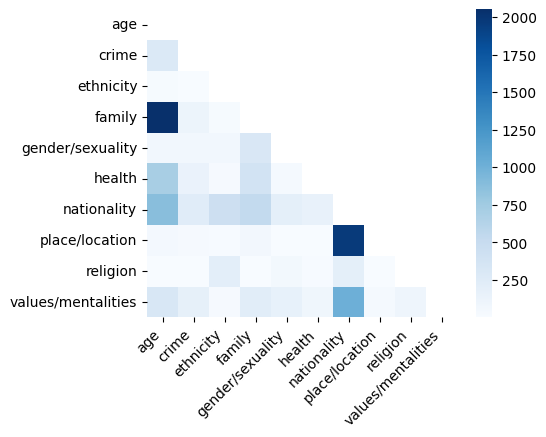

In [18]:
import seaborn as sns   
plt.figure(figsize=(5,4))
sns.heatmap(co_occurrence_df, annot=False, fmt='d', cmap='Blues')
plt.gca().set_xticklabels(plt.gca().get_xticklabels(), rotation=45, horizontalalignment='right')
plt.show()

## Embed the mentions

In [19]:
label_cols

['noneconomic__age',
 'noneconomic__crime',
 'noneconomic__ethnicity',
 'noneconomic__family',
 'noneconomic__gender_sexuality',
 'noneconomic__health',
 'noneconomic__nationality',
 'noneconomic__place_location',
 'noneconomic__religion',
 'noneconomic__shared_values_mentalities']

🚨 **<span style="color: red">Example:<span>** any mentions predicted to be in category "oneconomic__age"?

In [20]:
df_sample = mentions_df.query('noneconomic__age==1').copy()
len(df_sample)

7485

In [21]:
# # NOTE: let's sample down to 2,000 mentions for faster processing
# df_sample = df_sample.sample(2_000, random_state=42).reset_index(drop=True)

## Fuzzy clustering

We argue that social group mentions can use attributes from several different attribute categories simultaneously to discoursively define or describe a social group.
Identifying which attribute _categories_ are used in a given mention is only the first step to quantifying the attributes _values_ expressed in a social group mention, however.
We thus translate our argument of the necessity of a multi-labeling approach from the attribute category level to the attribute value level.
Here, we assume that every social group mention that uses a given attribut category can contain references to various attribute values.
For example, mentions that use attributes in the category "age" can refer to "young people", "old people", "pensioneers" etc.
And attribute values can be used in combination within a single mention (e.g., "young and old people").

We thus assume that every mention expresses the potential values of an attribute category to varying degrees.
The key challenge is that we do not know _a priori_ which attribute values might be realized in a corpus.
From a methodological perspective, this is a classic problem of "code set discovery," where we need to identify relevant codes (here: attribute values) from the data itself.

To tackle this problem, we build on ideas from _fuzzy clustering_.
Fuzzy clustering allows each data point to belong to multiple clusters with varying degrees of membership.
In our application, this means that a mention that uses attributes in a given category can be represented as a mixture of attribute values, each with a certain degree of membership.
That is, we treat group mentions as a distribution over latent attribute values, rather than assigning them to a single attribute value cluster.

**Goals statement**

1. discovering the latent attribute value structure in mentions that use a certain attribute category. This is important as we do not know _a priori_ all possible attribute values that might be expressed in a given corpus.
2. Understanding the concrete attribute values expressed in mentions that use a certain attribute category. For example, which age-based group mentions refer to younger people, which to older, and which to generations more encompassingly?
3. Quantifying how diffuse or concentrated mentions are in their expression of these attribute values. For example, do mentions tend to refer to a single age group (e.g., "the elderly") or do they refer to multiple age groups simultaneously (e.g., "the young and the old")?
4. Analyzing the (dis)similarity of mentions based on their attribute value distributions. For example, do mentions that refer to similar age groups cluster together in the attribute value space?

**Background: Computing word-cluster associations**

The presence or absence of a word or phrase can change a mention's association with a given cluster.
To quantify these associations, we compute how much each token in the vocabulary contributes to the membership values of each cluster.
This allows us to identify words that are strongly associated with each cluster, providing further insights into the attribute values represented by the clusters.

In particular, for each cluster, we take the logit-transformed value of mentions' membership degrees as an outcome an regress them on binarized bag-of-words document-term representations of the mentions.
In this way, we can estimate how the presence/absence of a token influence cluster membership degree.
To incenticvize sparse feature-cluster associations, we regularize coeeficient estimates by fitting an elastic net regression.

In [22]:
import numpy as np
import pandas as pd
from dataclasses import dataclass
from typing import Tuple, Optional
import logging
from sklearn.base import BaseEstimator, ClusterMixin
from sklearn.utils.validation import check_array, check_is_fitted
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import MultiTaskElasticNetCV
from sentence_transformers import SentenceTransformer
from umap import UMAP
from skfuzzy.cluster import cmeans, cmeans_predict
from scipy.spatial.distance import cdist
from scipy.stats import entropy
from scipy.special import expit
from nltk.stem import WordNetLemmatizer
from nltk import word_tokenize
from nltk.corpus import stopwords
import regex
import re
import torch
import torch.backends.mps
from tqdm import tqdm
from textwrap import fill
import matplotlib.pyplot as plt
import seaborn as sns
from typing import List

In [23]:
@dataclass
class VectorizerConfig:
    """Configuration for CountVectorizer and tokenization."""
    # N-gram configuration
    ngram_range: Tuple[int, int] = (1, 3)
    
    # Frequency filtering
    max_df: float = 0.8  # Ignore terms that appear in more than 80% of documents
    min_df: int = 2      # Ignore terms that appear in fewer than 2 documents
    max_features: Optional[int] = None  # Limit vocabulary size
    
    # Tokenization configuration
    remove_stopwords: bool = True
    min_token_length: int = 2
    max_token_length: int = 50
    filter_patterns: Optional[list] = None  # Regex patterns to filter out
    
    # Additional CountVectorizer settings
    lowercase: bool = True
    strip_accents: Optional[str] = 'unicode'  # Remove accents
    binary: bool = False  # If True, use binary term frequencies (0/1)

class Tokenizer:
    """
    Enhanced tokenizer for CountVectorizer with better control over preprocessing.
    
    Processes text in the following order:
    1. Lower case (handled by CountVectorizer's lowercase=True)
    2. Lemmatize tokens
    3. Remove stopwords
    4. Filter by token properties (length, patterns)
    """
    def __init__(self, 
                 remove_stopwords=True,
                 min_token_length=2,
                 max_token_length=50,
                 filter_patterns=None):
        """
        Initialize tokenizer.
        
        Parameters
        ----------
        remove_stopwords : bool
            Whether to remove stopwords
        min_token_length : int
            Minimum token length to keep
        max_token_length : int
            Maximum token length to keep
        filter_patterns : list of str, optional
            Regex patterns for tokens to filter out
        """
        self.lemmatizer = WordNetLemmatizer()
        self.remove_stopwords = remove_stopwords
        self.min_token_length = min_token_length
        self.max_token_length = max_token_length
        self.filter_patterns = filter_patterns or []
        
        if remove_stopwords:
            self.sws = set(stopwords.words('english'))
            # Add common non-informative words
            self.sws.update(['would', 'could', 'should', 'one', 'two', 'also', 'said', 'say'])
        else:
            self.sws = set()
        
        # Compile filter patterns
        self.compiled_patterns = [re.compile(pattern) for pattern in self.filter_patterns]
    
    def __call__(self, text):
        """
        Tokenize and process text.
        
        Note: CountVectorizer handles lowercasing before calling this method
        if lowercase=True is set.
        """
        # Tokenize
        tokens = word_tokenize(text)
        
        # Process each token
        processed_tokens = []
        for token in tokens:
            # Skip if stopword
            if self.remove_stopwords and token.lower() in self.sws:
                continue
            
            # Skip if too short or too long
            if len(token) < self.min_token_length or len(token) > self.max_token_length:
                continue
            
            # Skip if matches filter patterns
            if any(pattern.match(token) for pattern in self.compiled_patterns):
                continue
            
            # Skip if not alphabetic (numbers, punctuation, etc.)
            if not token.isalpha():
                continue
            
            # Lemmatize
            lemmatized = self.lemmatizer.lemmatize(token.lower())
            
            # Final length check after lemmatization
            if len(lemmatized) >= self.min_token_length:
                processed_tokens.append(lemmatized)
        
        return processed_tokens



In [24]:

@dataclass
class ClusteringConfig:
    """Configuration for fuzzy c-means clustering."""
    m: float = 2.0  # Fuzziness parameter
    error: float = 0.005  # Convergence threshold
    maxiter: int = 10_000  # Maximum iterations
    random_state: Optional[int] = None  # Will be set from Mapper's random_state if None

# Clustering Quality Metric Functions
def partition_coefficient(u_matrix: np.ndarray) -> float:
    """
    Compute the Partition Coefficient (PC) for fuzzy clustering.
    
    PC = (1/N) * sum(sum(u_ik^2))
    
    Parameters:
    -----------
    u_matrix : numpy.ndarray
        Fuzzy membership matrix of shape (n_clusters, n_samples)
        
    Returns:
    --------
    pc : float
        Partition coefficient value between 1/c and 1, where c is number of clusters.
        Higher values indicate better clustering (more crisp assignments).
    """
    n_samples = u_matrix.shape[1]
    pc = np.sum(u_matrix**2) / n_samples
    return pc


def partition_entropy(u_matrix: np.ndarray, base: float = np.e) -> float:
    """
    Compute the Partition Entropy (PE) for fuzzy clustering.
    
    PE = -(1/N) * sum(sum(u_ik * log(u_ik)))
    
    Parameters:
    -----------
    u_matrix : numpy.ndarray
        Fuzzy membership matrix of shape (n_clusters, n_samples)
    base : float
        Logarithm base (default=np.e for natural log, use 2 for log2, 10 for log10)
        
    Returns:
    --------
    pe : float
        Partition entropy value between 0 and log_base(c), where c is number of clusters.
        Lower values indicate better clustering (more crisp assignments).
    """
    n_samples = u_matrix.shape[1]
    epsilon = 1e-15
    u_safe = np.maximum(u_matrix, epsilon)
    
    if base == np.e:
        log_u = np.log(u_safe)
    elif base == 2:
        log_u = np.log2(u_safe)
    elif base == 10:
        log_u = np.log10(u_safe)
    else:
        log_u = np.log(u_safe) / np.log(base)
    
    pe = -np.sum(u_matrix * log_u) / n_samples
    return pe


def xie_beni_index(X: np.ndarray, u_matrix: np.ndarray, centers: np.ndarray, m: float = 2) -> float:
    """
    Compute the Xie-Beni Index (XB) for fuzzy clustering.
    
    XB = (sum_i sum_k u_{ik}^m ||x_i - v_k||^2) / (N * min_{k≠j} ||v_k - v_j||^2)
    
    Parameters:
    -----------
    X : numpy.ndarray
        Data matrix of shape (n_samples, n_features)
    u_matrix : numpy.ndarray
        Fuzzy membership matrix of shape (n_clusters, n_samples)
    centers : numpy.ndarray
        Cluster centers matrix of shape (n_clusters, n_features)
    m : float
        Fuzziness parameter (default=2)
        
    Returns:
    --------
    xb : float
        Xie-Beni index. Lower values indicate better clustering.
    """
    n_samples, n_features = X.shape
    n_clusters = u_matrix.shape[0]
    
    # Compute numerator
    numerator = 0
    for k in range(n_clusters):
        dists_squared = np.sum((X - centers[k])**2, axis=1)
        weights = u_matrix[k, :]**m
        numerator += np.sum(weights * dists_squared)
    
    # Compute denominator: N times minimum distance between cluster centers
    min_center_dist_squared = float('inf')
    for j in range(n_clusters):
        for k in range(j+1, n_clusters):
            center_dist_squared = np.sum((centers[j] - centers[k])**2)
            if center_dist_squared < min_center_dist_squared:
                min_center_dist_squared = center_dist_squared
    
    denominator = n_samples * min_center_dist_squared
    
    if denominator == 0 or min_center_dist_squared == 0:
        return float('inf')
    
    return numerator / denominator


def fukuyama_sugeno_index(X: np.ndarray, u_matrix: np.ndarray, centers: np.ndarray, m: float = 2) -> float:
    """
    Compute the Fukuyama–Sugeno Index (FS) for fuzzy clustering.
    
    FS = sum_i sum_k u_{ik}^m ||x_i - v_k||^2 - sum_k ||v_k - v̄||^2
    
    Parameters:
    -----------
    X : numpy.ndarray
        Data matrix of shape (n_samples, n_features)
    u_matrix : numpy.ndarray
        Fuzzy membership matrix of shape (n_clusters, n_samples)
    centers : numpy.ndarray
        Cluster centers matrix of shape (n_clusters, n_features)
    m : float
        Fuzziness parameter (default=2)
        
    Returns:
    --------
    fs : float
        Fukuyama-Sugeno index. Lower values indicate better clustering.
    """
    n_clusters = u_matrix.shape[0]
    
    # First term: sum_i sum_k u_{ik}^m ||x_i - v_k||^2
    first_term = 0
    for k in range(n_clusters):
        dists_squared = np.sum((X - centers[k])**2, axis=1)
        weights = u_matrix[k, :]**m
        first_term += np.sum(weights * dists_squared)
    
    # Second term: sum_k ||v_k - v̄||^2
    center_mean = np.mean(centers, axis=0)
    second_term = np.sum(np.sum((centers - center_mean)**2, axis=1))
    
    return first_term - second_term

class FuzzyCMeans(BaseEstimator, ClusterMixin):
    """
    Scikit-learn compatible wrapper for fuzzy c-means clustering.
    
    Parameters
    ----------
    n_clusters : int, default=8
        Number of clusters.
    config : ClusteringConfig, optional
        Clustering configuration object. If None, uses default ClusteringConfig.
    init : array-like, default=None
        Initial cluster centers. If None, random initialization is used.
    """
    
    def __init__(self, n_clusters=8, config=None, init=None):
        self.n_clusters = n_clusters
        self.config = config if config is not None else ClusteringConfig()
        self.init = init
    
    def fit(self, X, y=None):
        """Fit the fuzzy c-means clustering to X."""
        X = check_array(X)
        
        # cmeans expects data to be transposed (features x samples)
        cntr, u, u0, d, jm, p, fpc = cmeans(
            data=X.T,
            c=self.n_clusters,
            m=self.config.m,
            error=self.config.error,
            maxiter=self.config.maxiter,
            init=self.init,
            seed=self.config.random_state
        )
        
        # Store results
        self.cluster_centers_ = cntr
        self.u_ = u
        self.u0_ = u0
        self.d_ = d
        self.jm_ = jm
        self.p_ = p
        self.fpc_ = fpc
        
        # Compute quality metrics using standalone functions
        self.partition_coefficient_ = partition_coefficient(self.u_)
        self.partition_entropy_ = partition_entropy(self.u_)
        self.xie_beni_index_ = xie_beni_index(X, self.u_, self.cluster_centers_, m=self.config.m)
        self.fukuyama_sugeno_index_ = fukuyama_sugeno_index(X, self.u_, self.cluster_centers_, m=self.config.m)
        
        # For sklearn compatibility, store hard cluster assignments
        self.labels_ = np.argmax(u, axis=0)
        
        return self
    
    def transform(self, X):
        """Transform X to cluster membership matrix."""
        check_is_fitted(self, 'cluster_centers_')
        X = check_array(X)
        
        # Use the dedicated cmeans_predict function for more accurate predictions
        u, *_ = cmeans_predict(
            test_data=X.T,  # cmeans_predict expects transposed data (features x samples)
            cntr_trained=self.cluster_centers_,
            m=self.config.m,
            error=self.config.error,
            maxiter=self.config.maxiter,
            seed=self.config.random_state
        )
        
        # Return membership matrix transposed to (n_samples, n_clusters)
        return u.T
    
    def fit_transform(self, X, y=None):
        """Fit the model and transform the data."""
        self.fit(X, y)
        return self.u_.T
    
    def predict(self, X):
        """Predict the closest cluster each sample in X belongs to."""
        membership = self.transform(X)
        return np.argmax(membership, axis=1)
    
    @property
    def memberships(self):
        """Get the fuzzy membership matrix from training."""
        check_is_fitted(self, 'u_')
        return self.u_.T

In [25]:

@dataclass
class UMAPConfig:
    """Configuration for UMAP dimensionality reduction."""
    n_components: Optional[int] = None  # Will be set to embedding_dim//10 if None
    random_state: Optional[int] = None  # Will be set from Mapper's random_state if None
    n_jobs: int = 1
    n_neighbors: int = 15
    min_dist: float = 0.1
    metric: str = 'euclidean'


@dataclass
class ElasticNetConfig:
    """Configuration for multi-task elastic net."""
    l1_ratio: float = 0.7
    cv: int = 5
    fit_intercept: bool = True
    max_iter: int = 1_000
    n_alphas: int = 20
    random_state: Optional[int] = None  # Will be set from Mapper's random_state if None
    n_jobs: int = -1
    copy_x: bool = False


class Mapper:
    """
    A comprehensive class for fuzzy clustering of text mentions with semantic embeddings.
    
    This class integrates three main components:
    1. Embedder: Combines sentence embedding with dimensionality reduction and scaling
    2. Clusterer: Fuzzy c-means clustering model
    3. Describer: Multi-task elastic net for relating tokens to cluster membership
    """
    
    def __init__(self, 
                 embedding_model_name='haukelicht/all-mpnet-base-v2_noneconomic-attributes-classifier',
                 umap_config=None,
                 clustering_config=None,
                 elastic_net_config=None,
                 vectorizer_config=None,
                 random_state=42,
                 device=None):
        """
        Initialize the Mapper with all components and parameters.
        
        Parameters
        ----------
        embedding_model_name : str
            Name or path of the sentence transformer model
        umap_config : UMAPConfig, optional
            UMAP configuration. If None, uses default UMAPConfig.
        clustering_config : ClusteringConfig, optional
            Clustering configuration. If None, uses default ClusteringConfig.
        elastic_net_config : ElasticNetConfig, optional
            ElasticNet configuration. If None, uses default ElasticNetConfig.
        vectorizer_config : VectorizerConfig, optional
            Vectorizer configuration. If None, uses default VectorizerConfig.
        random_state : int
            Global random state
        device : str, optional
            Device for embedding model. If None, auto-detected
        """
        
        # Store parameters and configs
        self.embedding_model_name = embedding_model_name
        self.random_state = random_state
        
        # Initialize configs and set random_state if not specified
        self.umap_config = umap_config if umap_config is not None else UMAPConfig()
        if self.umap_config.random_state is None:
            self.umap_config.random_state = self.random_state
            
        self.clustering_config = clustering_config if clustering_config is not None else ClusteringConfig()
        if self.clustering_config.random_state is None:
            self.clustering_config.random_state = self.random_state
            
        self.elastic_net_config = elastic_net_config if elastic_net_config is not None else ElasticNetConfig()
        self.vectorizer_config = vectorizer_config if vectorizer_config is not None else VectorizerConfig()
        
        # Set device
        if device is None:
            self.device = 'cuda' if torch.cuda.is_available() else 'mps' if torch.backends.mps.is_available() else 'cpu'
        else:
            self.device = device
        
        # Initialize components
        self.embedder = None
        self.umap_model = None
        self.scaler = None
        self.clusterer = None
        self.vectorizer = None
        self.describer = None
        
        # Initialize components (but don't fit yet)
        self._init_components()
    
    
    def _init_components(self):
        """Initialize UMAP, scaler, and vectorizer components."""
        
        self.embedder = SentenceTransformer(self.embedding_model_name, device=self.device)
        
        # Set UMAP components if not specified in config
        if self.umap_config.n_components is None:
            self.umap_config.n_components = self.embedder.get_sentence_embedding_dimension() // 10
    
        self.umap_model = UMAP(
            n_components=self.umap_config.n_components,
            random_state=self.umap_config.random_state,
            n_jobs=self.umap_config.n_jobs,
            n_neighbors=self.umap_config.n_neighbors,
            min_dist=self.umap_config.min_dist,
            metric=self.umap_config.metric
        )
        logging.info("Initializing StandardScaler for feature scaling")
        self.scaler = StandardScaler()
        
        # Initialize tokenizer
        logging.info("Initializing text vectorizer and tokenizer")
        logging.info(f"Vectorizer config: ngram_range={self.vectorizer_config.ngram_range}, max_df={self.vectorizer_config.max_df}, min_df={self.vectorizer_config.min_df}")
        tokenizer = Tokenizer(
            remove_stopwords=self.vectorizer_config.remove_stopwords,
            min_token_length=self.vectorizer_config.min_token_length,
            max_token_length=self.vectorizer_config.max_token_length,
            filter_patterns=self.vectorizer_config.filter_patterns
        )
        
        self.vectorizer = CountVectorizer(
            tokenizer=tokenizer,
            token_pattern=None,  # Use custom tokenizer
            lowercase=self.vectorizer_config.lowercase,  # Handle lowercasing before tokenization
            strip_accents=self.vectorizer_config.strip_accents,
            ngram_range=self.vectorizer_config.ngram_range,
            max_df=self.vectorizer_config.max_df,
            min_df=self.vectorizer_config.min_df,
            max_features=self.vectorizer_config.max_features,
            binary=self.vectorizer_config.binary
        )
    
    def _preprocess_text(self, texts):
        """
        Minimal text preprocessing for the vectorizer.
        
        Note: Most preprocessing is now handled by the Tokenizer
        within CountVectorizer. This method now only does basic cleanup.
        """
        def clean_text(text):
            # Basic cleanup: normalize whitespace and strip
            text = re.sub(r'\s+', ' ', text).strip()
            return text
        
        if isinstance(texts, (list, tuple)):
            return [clean_text(text) for text in texts]
        else:
            return clean_text(texts)
    
    def _embed(self, texts):
        """
        Embed texts, reduce dimensionality, and scale.
        
        Parameters
        ----------
        texts : list of str
            Input texts to embed
            
        Returns
        -------
        embeddings_scaled : np.ndarray
            Scaled reduced embeddings
        """
        # Check if UMAP and scaler are fitted using sklearn's check_is_fitted
        from sklearn.utils.validation import check_is_fitted
        
        # Generate embeddings
        embeddings = self.embedder.encode(
            texts, 
            normalize_embeddings=True, 
            convert_to_numpy=True,
            show_progress_bar=True
        )
        
        # check if umap model has been fitted and fit if not
        try:
            check_is_fitted(self.umap_model)
        except:
            print("fitting UMAP model...")
            self.umap_model.fit(embeddings)
        finally:
            # Reduce dimensionality
            embeddings_reduced = self.umap_model.transform(embeddings)
        
        # check if scaler has been fitted and fit if not
        try:
            check_is_fitted(self.scaler)
        except:
            print("fitting scaler...")
            self.scaler.fit(embeddings_reduced)
        finally:
            # Scale
            embeddings_scaled = self.scaler.transform(embeddings_reduced)
        
        return embeddings_scaled
    
    def _cluster(self, embeddings_scaled, k):
        """
        Fit fuzzy k-means clustering model.
        
        Parameters
        ----------
        embeddings_scaled : np.ndarray
            Scaled embeddings
        k : int
            Number of clusters
            
        Returns
        -------
        clusterer : FuzzyCMeans
            Fitted clustering model
        """
        clusterer = FuzzyCMeans(
            n_clusters=k,
            config=self.clustering_config
        )
        
        clusterer.fit(embeddings_scaled)
        return clusterer
    
    def search_k(self, texts: Optional[List[str]]=None, embeddings_scaled: Optional[np.ndarray]=None, k_values: List[int]=[10, 15, 20]):
        """
        Try multiple clustering configurations and return quality metrics.
        
        Parameters
        ----------
        embeddings_scaled : np.ndarray
            Scaled embeddings
        k_values : list of int
            List of k values to try
            
        Returns
        -------
        metrics_df : pd.DataFrame
            DataFrame with clustering quality metrics for each k
        """
        if embeddings_scaled is None:
            if texts is None:
                raise ValueError("Either texts or embeddings_scaled must be provided.")
            embeddings_scaled = self._embed(texts)
        
        metrics = {}
        
        for k in tqdm(k_values, desc="Trying different k values"):
            clusterer = self._cluster(embeddings_scaled, k)
            
            metrics[k] = {
                'k': k,
                'partition_coefficient': clusterer.partition_coefficient_,
                'partition_entropy': clusterer.partition_entropy_,
                'xie_beni_index': clusterer.xie_beni_index_,
                'fukuyama_sugeno_index': clusterer.fukuyama_sugeno_index_
            }
        
        self.clustering_metrics_ = pd.DataFrame.from_dict(metrics, orient='index')
        return self.clustering_metrics_
    
    def fit(self, texts, k, estimate_feature_weights: bool=False):
        """
        Fit the complete model: embedder, clusterer, and describer.
        
        Parameters
        ----------
        texts : list of str
            Input texts
        k : int
            Number of clusters
            
        Returns
        -------
        self : Mapper
            Fitted mapper instance
        """
        logging.info(f"=== Starting Mapper Training ===")
        logging.info(f"Number of texts: {len(texts)}")
        logging.info(f"Number of clusters (k): {k}")
        logging.info(f"Estimate feature weights: {estimate_feature_weights}")
        
        # Store original texts
        self.texts_ = texts
        
        # Generate embeddings
        logging.info("Step 1/5: Generating sentence embeddings")
        embeddings = self.embedder.encode(
            texts, 
            normalize_embeddings=True, 
            convert_to_numpy=True,
            show_progress_bar=True
        )
        logging.info(f"Generated embeddings shape: {embeddings.shape}")
        logging.info(f"Step 2/5: Reducing dimensionality with UMAP (to {self.umap_config.n_components} dimensions)")
        embeddings_reduced = self.umap_model.fit_transform(embeddings)
        logging.info(f"Reduced embeddings shape: {embeddings_reduced.shape}")
        
        # Fit scaler and scale
        logging.info("Step 3/5: Scaling features with StandardScaler")
        embeddings_scaled = self.scaler.fit_transform(embeddings_reduced)
        logging.info(f"Scaled embeddings shape: {embeddings_scaled.shape}")
        
        
        # Fit clusterer
        self.clusterer = self._cluster(embeddings_scaled, k)

        # Fit describer
        if estimate_feature_weights:
            self._fit_describer(texts)
        
        return self
    
    def fit_transform(self, texts, k, estimate_feature_weights: bool=False):
        """
        Fit the model and return cluster membership matrix.
        
        Parameters
        ----------
        texts : list of str
            Input texts
        k : int
            Number of clusters
            
        Returns
        -------
        memberships : np.ndarray
            Cluster membership matrix (n_samples, n_clusters)
        """
        self.fit(texts, k, estimate_feature_weights=estimate_feature_weights)
        return self.clusterer.memberships
    
    def _fit_describer(self, texts):
        """
        Fit the describer (multi-task elastic net) to relate tokens to cluster membership.
        
        Parameters
        ----------
        """
        logging.info("  5a: Preprocessing texts for vectorization")
        texts_clean = self._preprocess_text(texts)
        
        # Fit vectorizer and transform texts
        logging.info("  5b: Fitting text vectorizer and creating document-term matrix")
        dtm = self.vectorizer.fit_transform(texts_clean)
        logging.info(f"  Document-term matrix shape: {dtm.shape}")
        logging.info(f"  Vocabulary size: {len(self.vectorizer.get_feature_names_out())}")
        logging.info(f"  Matrix sparsity: {1 - (dtm.nnz / (dtm.shape[0] * dtm.shape[1])):.3f}")
        
        # # Store DTM for vocabulary analysis
        # self._dtm = dtm
        
        # Get membership matrix and apply logit transformation
        u = self.clusterer.u_  # (n_clusters, n_samples)
        y = u.T  # (n_samples, n_clusters)
        
        # Clip values to avoid log(0) and log(1)
        eps = 1e-6
        y_clipped = np.clip(y, eps, 1 - eps)
        
        # Apply logit transformation
        y_logit = np.log(y_clipped / (1 - y_clipped))
        
        logging.info("  5c: Training multi-task ElasticNet for token-cluster relationships")
        logging.info(f"  ElasticNet config: l1_ratio={self.elastic_net_config.l1_ratio}, cv={self.elastic_net_config.cv}")
        self.describer = MultiTaskElasticNetCV(
            l1_ratio=self.elastic_net_config.l1_ratio,
            cv=self.elastic_net_config.cv,
            fit_intercept=self.elastic_net_config.fit_intercept,
            max_iter=self.elastic_net_config.max_iter,
            n_alphas=self.elastic_net_config.n_alphas,
            n_jobs=self.elastic_net_config.n_jobs,
            copy_X=self.elastic_net_config.copy_x,
            random_state=self.random_state
        )
        self.describer.fit(dtm.toarray(), y_logit)
        logging.info("  5d: Converting coefficients to probability space")
        coefs = pd.DataFrame(
            self.describer.coef_.T, 
            columns=range(self.clusterer.n_clusters), 
            index=self.vectorizer.get_feature_names_out()
        )
        self.feature_coefficients_ = coefs.transform(expit, axis=1)
        
        logging.info("=== Mapper Training Completed Successfully! ===")
        return self
    
    def transform(self, texts):
        """
        Transform new texts to cluster membership matrix.
        
        Parameters
        ----------
        texts : list of str
            New texts to transform
            
        Returns
        -------
        memberships : np.ndarray
            Cluster membership matrix (n_samples, n_clusters)
        """
        logging.info(f"Transforming {len(texts)} new texts to cluster memberships")
        embeddings_scaled = self._embed(texts)
        memberships = self.clusterer.transform(embeddings_scaled)
        logging.info(f"Generated membership matrix shape: {memberships.shape}")
        return memberships
    
    def predict(self, texts):
        """
        Predict hard cluster assignments for new texts.
        
        Parameters
        ----------
        texts : list of str
            New texts to predict
            
        Returns
        -------
        labels : np.ndarray
            Hard cluster assignments (n_samples,)
        """
        memberships = self.transform(texts)
        return np.argmax(memberships, axis=1)
    
    def get_representative_texts(self, cluster_id, top_n=20):
        """
        Get representative texts for a specific cluster.
        
        Parameters
        ----------
        cluster_id : int
            Cluster ID
        top_n : int
            Number of top texts to return
            
        Returns
        -------
        df : pd.DataFrame
            DataFrame with representative texts and their membership values
        """
        if not hasattr(self, 'clusterer') or self.clusterer is None:
            raise ValueError("Model must be fitted first")
        
        u = self.clusterer.u_
        idxs = u[cluster_id, :].argsort()[::-1][:top_n]
        vals = u[cluster_id, idxs]
        texts = [self.texts_[i] for i in idxs]
        
        return pd.DataFrame({
            'text': texts,
            'cluster_id': [cluster_id] * top_n,
            'membership_value': vals
        })
    
    def get_cluster_keywords(self, cluster_id, top_n=10):
        """
        Get top keywords associated with a cluster.
        
        Parameters
        ----------
        cluster_id : int
            Cluster ID
        top_n : int
            Number of top keywords to return
            
        Returns
        -------
        keywords : pd.Series
            Top keywords with their coefficients
        """
        if not hasattr(self, 'feature_coefficients_') or self.feature_coefficients_ is None:
            raise ValueError("Describer must be fitted first")
        
        return self.feature_coefficients_[cluster_id].sort_values(ascending=False).head(top_n)
    
    def compute_membership_entropy(self, base=2):
        """
        Compute entropy for each sample's cluster membership distribution.
        
        Parameters
        ----------
        base : int or float
            Logarithm base for entropy calculation
            
        Returns
        -------
        entropies : np.ndarray
            Entropy for each sample
        normalized_entropies : np.ndarray
            Normalized entropies (0 to 1 scale)
        """
        if not hasattr(self, 'clusterer') or self.clusterer is None:
            raise ValueError("Model must be fitted first")
        
        u = self.clusterer.u_
        entropies = np.apply_along_axis(lambda col: entropy(col, base=base), axis=0, arr=u)
        
        # Normalized entropy
        if base == 2:
            max_entropy = np.log2(self.clusterer.n_clusters)
        elif base == np.e:
            max_entropy = np.log(self.clusterer.n_clusters)
        elif base == 10:
            max_entropy = np.log10(self.clusterer.n_clusters)
        else:
            max_entropy = np.log(self.clusterer.n_clusters) / np.log(base)
        
        normalized_entropies = entropies / max_entropy
        
        return entropies, normalized_entropies
    
    def plot_clustering_metrics(self, clustering_metrics=None, figsize=(12, 8)):
        """
        Plot clustering quality metrics for different k values.
        
        Parameters
        ----------
        k_values : list of int, optional
            List of k values to evaluate. If None, uses previously computed metrics.
        clustering_metrics : pd.DataFrame, optional
            DataFrame with clustering metrics. If None, computes metrics for given k_values.
        """
        if clustering_metrics is not None:
            metrics_df = clustering_metrics
        elif hasattr(self, 'clustering_metrics_') and self.clustering_metrics_ is not None:
            metrics_df = self.clustering_metrics_
        else:
            raise ValueError("No clustering metrics available. Use search_k() first.")
        
        _, axes = plt.subplots(2, 2, figsize=figsize)
        
        # Partition Coefficient (higher = better)
        axes[0, 0].plot(metrics_df['k'], metrics_df['partition_coefficient'], marker='o')
        axes[0, 0].set_title('Partition Coefficient (higher = better)')
        axes[0, 0].set_xlabel('k')
        axes[0, 0].set_xticks(metrics_df['k'])
        axes[0, 0].set_ylabel('PC')
        axes[0, 0].grid(True)
        
        # Partition Entropy (lower = better)
        axes[0, 1].plot(metrics_df['k'], metrics_df['partition_entropy'], marker='o')
        axes[0, 1].set_title('Partition Entropy (lower = better)')
        axes[0, 1].set_xlabel('k')
        axes[0, 1].set_xticks(metrics_df['k'])
        axes[0, 1].set_ylabel('PE')
        axes[0, 1].grid(True)
        
        # Xie-Beni Index (lower = better)
        axes[1, 0].plot(metrics_df['k'], metrics_df['xie_beni_index'], marker='o')
        axes[1, 0].set_title('Xie-Beni Index (lower = better)')
        axes[1, 0].set_xlabel('k')
        axes[1, 0].set_xticks(metrics_df['k'])
        axes[1, 0].set_ylabel('XBI')
        axes[1, 0].grid(True)
        
        # Fukuyama-Sugeno Index (lower = better)
        axes[1, 1].plot(metrics_df['k'], metrics_df['fukuyama_sugeno_index'], marker='o')
        axes[1, 1].set_title('Fukuyama-Sugeno Index (lower = better)')
        axes[1, 1].set_xlabel('k')
        axes[1, 1].set_xticks(metrics_df['k'])
        axes[1, 1].set_ylabel('FSI')
        axes[1, 1].grid(True)
        axes[1, 1].grid(True)
        plt.tight_layout()
        plt.show()
        
        return metrics_df
    
    def plot_clusters_2d(self, show_labels=True, figsize=(10, 8)):
        """
        Plot clusters in 2D UMAP space.
        
        Parameters
        ----------
        show_labels : bool
            Whether to show cluster center labels
        figsize : tuple
            Figure size
        """
        if not hasattr(self, 'clusterer') or self.clusterer is None:
            raise ValueError("Model must be fitted first")
        
        # Create 2D UMAP for visualization
        umap_2d = UMAP(n_components=2, random_state=self.umap_config.random_state, n_jobs=1)
        embeddings_2d = umap_2d.fit_transform(self.clusterer.memberships)
        embeddings_2d = umap_2d.fit_transform(self.clusterer.memberships)
        # Transform cluster centers to 2D
        centers_2d = umap_2d.transform(self.clusterer.transform(self.clusterer.cluster_centers_))
        
        # Create color palette
        k = self.clusterer.n_clusters
        palette = sns.color_palette("hsv", k)
        from matplotlib.colors import ListedColormap
        custom_cmap = ListedColormap(palette)
        
        plt.figure(figsize=figsize)
        scatter = plt.scatter(
            embeddings_2d[:, 0], 
            embeddings_2d[:, 1], 
            c=np.argmax(self.clusterer.u_, axis=0), 
            cmap=custom_cmap, 
            s=5, 
            alpha=0.7
        )
        
        plt.title(f'Fuzzy C-Means Clustering (k={k})')
        plt.xlabel('UMAP Dimension 1')
        plt.ylabel('UMAP Dimension 2')
        plt.colorbar(scatter)
        
        if show_labels:
            # Find closest mentions to cluster centers for labeling
            from scipy.spatial.distance import cdist
            closest_mentions = []
            for i in range(k):
                dists = cdist(embeddings_2d, centers_2d[i].reshape(1, -1), metric='euclidean')
                closest_idx = np.argmin(dists)
                closest_mentions.append(closest_idx)
            
            # Add labels
            for c, i in enumerate(closest_mentions):
                mention_text = fill(self.texts_[i], width=20, break_long_words=False, subsequent_indent='  ')
                x, y = centers_2d[c]
                plt.text(x, y, mention_text, fontsize=8, alpha=0.9)
        
        plt.show()
    
    def plot_membership_heatmap(self, n_samples=10, figsize=(12, 4)):
        """
        Plot membership heatmap for sample mentions.
        
        Parameters
        ----------
        n_samples : int
            Number of samples to show
        figsize : tuple
            Figure size
        """
        if not hasattr(self, 'clusterer') or self.clusterer is None:
            raise ValueError("Model must be fitted first")
        
        memberships = self.clusterer.memberships
        
        plt.figure(figsize=figsize)
        sns.heatmap(
            memberships[:n_samples, :].round(3), 
            cmap='Blues', 
            vmin=0, 
            vmax=1, 
            annot=False
        )
        
        # Set y-axis labels with text samples
        sample_texts = [f'"{text}"' for text in self.texts_[:n_samples]]
        plt.yticks(
            ticks=np.arange(0.5, n_samples + 0.5), 
            labels=sample_texts, 
            rotation=0, 
            fontsize=9
        )
        plt.xlabel('Cluster')
        plt.title('Fuzzy Membership Matrix')
        plt.show()

### Using the Mapper class

Now let's demonstrate how to use the refactored `Mapper` class with your existing data:

In [26]:
# Init configs
seed = 42
umap_config=UMAPConfig(random_state=seed)
clustering_config=ClusteringConfig(random_state=seed)
elastic_net_config=ElasticNetConfig(random_state=seed)
vectorizer_config=VectorizerConfig(binary=True, filter_patterns=[r'^\d+$', r'^[A-Z]+$'])

# Initialize the Mapper with your existing configuration
mapper = Mapper(
    embedding_model_name='haukelicht/all-mpnet-base-v2_noneconomic-attributes-classifier',
    umap_config=umap_config,
    clustering_config=clustering_config,
    elastic_net_config=elastic_net_config,
    vectorizer_config=vectorizer_config,
    random_state=seed
)

You are trying to use a model that was created with Sentence Transformers version 5.1.0, but you're currently using version 4.1.0. This might cause unexpected behavior or errors. In that case, try to update to the latest version.


#### Finding best _k_

In [27]:
ks = list()
ks += list(range(15, 45, 5))
ks += list(range(45, 66, 10))

metrics_df = mapper.search_k(texts=df_sample.text.tolist(), k_values=ks)

Batches:   0%|          | 0/234 [00:00<?, ?it/s]

fitting UMAP model...
fitting scaler...
fitting scaler...


Trying different k values: 100%|██████████| 9/9 [02:11<00:00, 14.65s/it]


In [29]:
metrics_df

,k,partition_coefficient,partition_entropy,xie_beni_index,fukuyama_sugeno_index
15,15,0.163010,2.324633,8.261919e+08,33576.528748
20,20,0.135151,2.605165,3.064449e+16,25004.120290
25,25,0.105413,2.887875,6.919316e+08,20567.682708
30,30,0.087696,3.091625,4.533766e+06,17079.893983
35,35,0.089108,3.177346,1.403644e+14,13798.785628
40,40,0.074211,3.358075,1.231685e+14,12380.661961
45,45,0.066916,3.484878,3.243021e+13,10912.351353
55,55,0.059948,3.697176,2.753657e+14,8916.394316
65,65,0.048612,3.904382,3.926185e+09,7495.208225


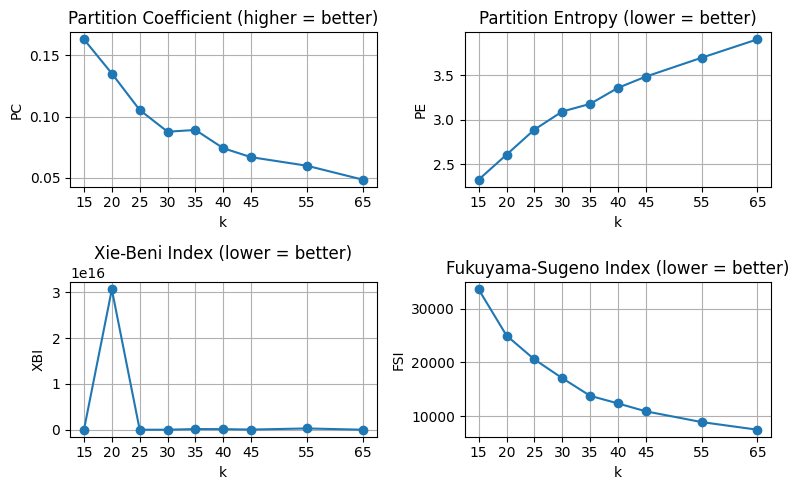

In [28]:
mapper.plot_clustering_metrics(clustering_metrics=metrics_df, figsize=(8, 5));

#### Fitting the final model

In [30]:
memberships = mapper.fit_transform(df_sample.text.tolist(), k=35, estimate_feature_weights=True)

Batches:   0%|          | 0/234 [00:00<?, ?it/s]

#### Understanding fuzzy cluster assignments

The figure below visualizes what fuzzy clustering means for mentions' membership in the estimated clusters in our sample of mentions predicted to use age-related attributes.
It shows that mentions have varying levels of "membership" across multiple clusters, indicating that they express multiple attribute values to varying degrees.

- Some mentions, like "children with dyslexia and ADHD", are almost exclusively concentrated in a single cluster.
- Others, like "elderly fellow citizens living in old-age homes and nursing homes"; have more distributed membership.
- Further, similar mentions like "Elderly doctors" and "elderly fellow citizens living in old-age homes and nursing homes" have similar _membership profiles_, indicating that they tap into similar attribute values.

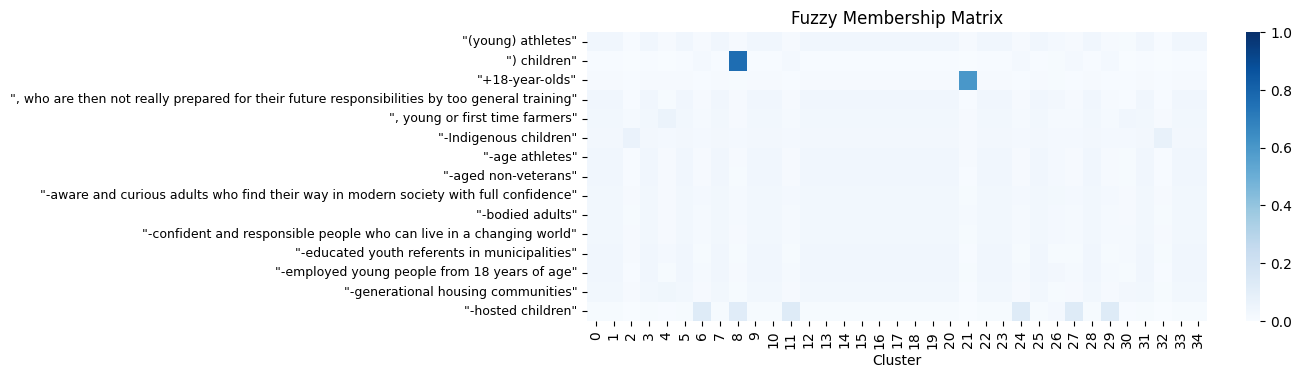

In [31]:
# Show membership heatmap
n_ = 15
mapper.plot_membership_heatmap(n_samples=n_, figsize=(10, n_/4))

These similarities across mentions fuzzy cluster memberships mean that there is a latent space of attribute values that these mentions reference to varying degrees.
This becomes clear if we reduce the variation in the fuzzy cluster membership space to two dimensions using UMAP:. 

In [32]:
# Visualize the results
mapper.plot_clusters_2d(figsize=(12, 10))

KeyboardInterrupt: 

How diffuse a mention is (in contrast to concentrated and "crisp") can be quantified using the normalized entropy metric.
This metric has the theoretical range of 0 to 1, where 0 would indicates that a mention is fully concentrated in a single cluster (i.e., it strongly expresses a single attribute value), and 1 would indicate that a mention is evenly distributed across all clusters (i.e., it weakly expresses multiple attribute values).
Figure `X` shows the distribution of normalized entropy values across all mentions in our age-related attribute mention sample.
It shows that the majority of mentions have entropy values in the range 0.4 to 0.8, indicating that they tend to be somewhat diffuse in their expression of attribute values.

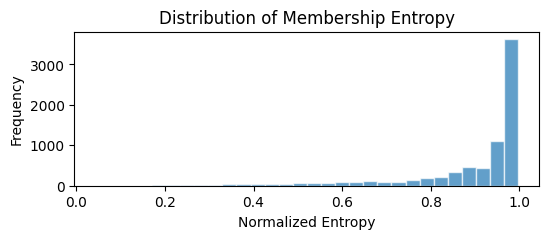

In [33]:
# Compute membership entropy to understand diffuseness
entropies, normalized_entropies = mapper.compute_membership_entropy()

# print(f"Entropy statistics:")
# print(f"  Mean: {normalized_entropies.mean():.3f}")
# print(f"  Std: {normalized_entropies.std():.3f}")
# print(f"  Range: [{normalized_entropies.min():.3f}, {normalized_entropies.max():.3f}]")

# Plot entropy distribution
plt.figure(figsize=(6, 2))
plt.hist(normalized_entropies, bins=30, edgecolor='white', alpha=0.7)
plt.xlabel('Normalized Entropy')
plt.ylabel('Frequency')
plt.title('Distribution of Membership Entropy')
plt.show()


Figure `X` below shows example mentions with low, medium, and high normalized entropy values, illustrating how the degree of diffuseness varies across mentions.

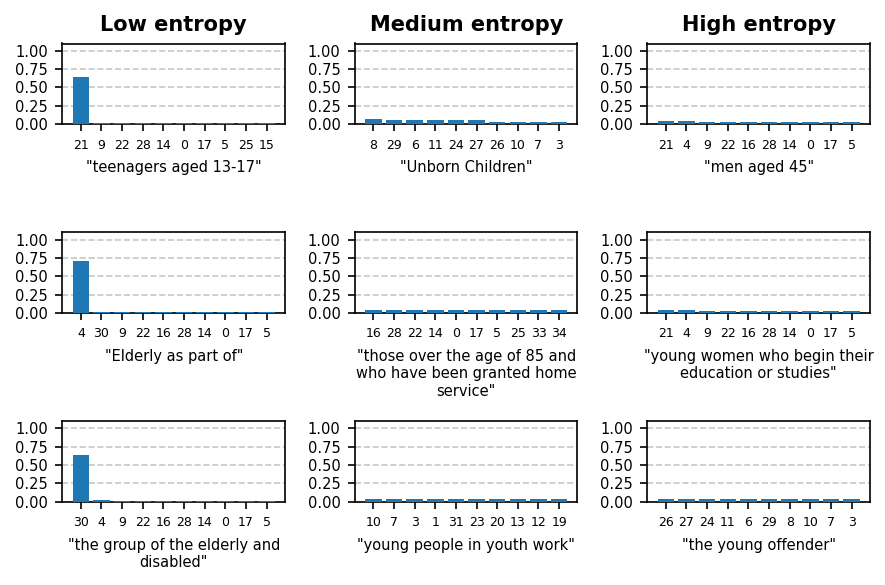

In [34]:
from textwrap import fill
n_bins = 11

bins = pd.qcut(normalized_entropies, n_bins, labels=False)

low = np.where(bins == 0)[0]
medium = np.where(bins == n_bins//2)[0]
high = np.where(bins == n_bins-1)[0]


n_col = 3
n_rows = 3
# sample `n_rows` examples from each bin
rng = np.random.default_rng(42)
low = rng.choice(low, n_rows, replace=False)
medium = rng.choice(medium, n_rows, replace=False)
high = rng.choice(high, n_rows, replace=False)

n_ = n_col * n_rows
frac_ = 2/3
fig, axes = plt.subplots(n_rows, n_col, figsize=(n_col*3*frac_, n_rows*2*frac_), dpi=150)
top_ = 10

top_clusters = set()
idxs = [low, medium, high]
for r, ax in enumerate(axes):
    for c, idx in enumerate(idxs):
        ax = axes[r, c]
        if r==0:
            val = ['Low', 'Medium', 'High'][c]
            ax.set_title(f'{val} entropy', fontdict={'fontsize': 10, 'weight': 'bold'})
        i = idx[r]
        ax.set_ylim(0, 1.1)
        ax.set_yticks(np.linspace(0, 1, 5))
        ax.set_yticklabels([f'{y:.2f}' for y in np.linspace(0, 1, 5)], fontsize=7)
        ax.grid(True, axis='y', linestyle='--', alpha=0.7)
        these = memberships[i, :].argsort()[::-1][:top_]
        top_clusters.add(these[0])
        ax.bar(range(top_), memberships[i, these], zorder=3)
        ax.set_xticks(range(top_))
        ax.set_xticklabels(these, va='top', ha='center', fontsize=6)
        # ax.set_xlabel('Cluster')
        m = fill(df_sample.text.iloc[i], width=30, break_long_words=False)
        ax.set_xlabel(f'"{m}"', fontdict={'fontsize': 7})
plt.tight_layout()

#### Interpreting clusters

While the idea of fuzzy membership is attractive for conceptual reasons, it poses challenges for interpretation.
Onlike in deductive, supervised learning approaches, where we can directly map predicted labels to known attribute categories, fuzzy clustering produces latent clusters that do not have inherent meaning.
We use two strategies commonly applied in the topic modeling literature to interpret these clusters:

1. **Examining high-membership mentions**: For each cluster, we identify mentions with high membership values and qualitatively analyze their content to infer the underlying attribute value represented by the cluster.
2. **Word-cluster associations**: We compute how much tokens in mentions contribute to cluster memberships, allowing us to identify words that are strongly associated with each cluster.
3. **Cluster associations**: Cluster co-expression patterns across mentions can also provide insights into how clusters relate to each other, revealing potential higher-order attribute value groupings and underlying ontologies.

In [35]:
# Analyze specific clusters
cluster_id = 0
print(f"=== Cluster {cluster_id} Analysis ===")

# Get representative texts
rep_texts = mapper.get_representative_texts(cluster_id, top_n=5)
print("\nTop representative texts:")
for i, row in rep_texts.iterrows():
    print(f"  {row['membership_value']:.3f}: {row['text']}")

# Get top keywords
keywords = mapper.get_cluster_keywords(cluster_id, top_n=10)
print(f"\nTop keywords for cluster {cluster_id}:")
for word, coef in keywords.items():
    print(f"  {coef:.4f}: {word}")

=== Cluster 0 Analysis ===

Top representative texts:
  0.041: persons of voting age
  0.041: -wing youth
  0.041: elected young people
  0.041: the next generation of Islamic youth
  0.041: the youth class

Top keywords for cluster 0:
  0.6647: american child
  0.6202: child immigrant
  0.6077: child aged
  0.5835: rom child
  0.5783: disabled child
  0.5764: child america
  0.5742: child age
  0.5716: child country
  0.5707: child year
  0.5697: veteran


In [36]:
# Analyze specific clusters
cluster_id = 1
print(f"=== Cluster {cluster_id} Analysis ===")

# Get representative texts
rep_texts = mapper.get_representative_texts(cluster_id, top_n=5)
print("\nTop representative texts:")
for i, row in rep_texts.iterrows():
    print(f"  {row['membership_value']:.3f}: {row['text']}")

# Get top keywords
keywords = mapper.get_cluster_keywords(cluster_id, top_n=10)
print(f"\nTop keywords for cluster {cluster_id}:")
for word, coef in keywords.items():
    print(f"  {coef:.4f}: {word}")

=== Cluster 1 Analysis ===

Top representative texts:
  0.041: persons of voting age
  0.041: -wing youth
  0.041: elected young people
  0.041: the next generation of Islamic youth
  0.041: the youth class

Top keywords for cluster 1:
  0.6647: american child
  0.6202: child immigrant
  0.6077: child aged
  0.5835: rom child
  0.5783: disabled child
  0.5764: child america
  0.5742: child age
  0.5716: child country
  0.5707: child year
  0.5697: veteran


In [37]:
cluster_id = 2
print(f"=== Cluster {cluster_id} Analysis ===")

# Get representative texts
rep_texts = mapper.get_representative_texts(cluster_id, top_n=5)
print("\nTop representative texts:")
for i, row in rep_texts.iterrows():
    print(f"  {row['membership_value']:.3f}: {row['text']}")

# Get top keywords
keywords = mapper.get_cluster_keywords(cluster_id, top_n=10)
print(f"\nTop keywords for cluster {cluster_id}:")
for word, coef in keywords.items():
    print(f"  {coef:.4f}: {word}")

=== Cluster 2 Analysis ===

Top representative texts:
  0.768: young people with little or no experience of wider British society
  0.765: Poles of all ages, belonging to different backgrounds and
  0.745: a National Youth protagonist of the fate of Italy
  0.728: young Poles from other countries
  0.695: Polish youth permanently residing abroad

Top keywords for cluster 2:
  0.9531: hungarian
  0.9510: american
  0.9349: citizen
  0.9250: european
  0.9137: pole
  0.9130: britain
  0.9051: british
  0.9023: immigrant
  0.8968: america
  0.8958: migrant


### induce hierarchical cluster

The example of clusters related to offenders and the semantic overlap between their representative mentions suggest that the estimated clusters might have hierarchical relations.

In [38]:
from sklearn.cluster import AgglomerativeClustering

# compute distances between samples fuzzy cluster memberships using thie Jensen-Shannon divergence

agglo_model = AgglomerativeClustering(n_clusters=None, distance_threshold=0.1, linkage='ward')
agglo_model.fit(memberships.T)

AgglomerativeClustering(distance_threshold=0.1, n_clusters=None)

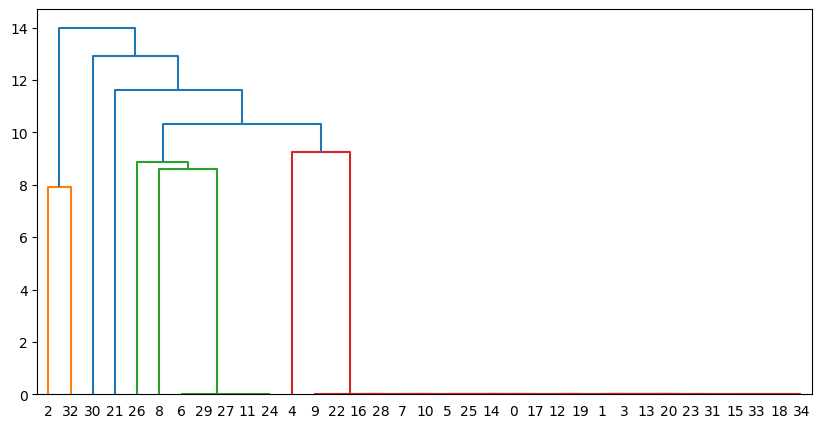

In [39]:
# show dendrogram
from scipy.cluster.hierarchy import dendrogram

def plot_dendrogram(model, **kwargs):
    # Create linkage matrix and then plot the dendrogram

    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack([model.children_, model.distances_, counts]).astype(float)

    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)

plt.figure(figsize=(10, 5))
plot_dendrogram(agglo_model, truncate_mode=None, orientation='top', leaf_rotation=0, leaf_font_size=10)

In [68]:
# illness + age
for c in [16, 33]:
    print(f"\n\033[1mCluster {c}\033[0m")
    print(f" Influential terms for cluster {c}:\n ", mapper.get_cluster_keywords(c, top_n=5).index.tolist())
    print(f" Repr. mentions for cluster {c}:", *mapper.get_representative_texts(c, top_n=5).text.tolist(), sep='\n  - ')


Cluster 16
 Influential terms for cluster 16:
  ['family', 'couple', 'parent', 'grandparent', 'mother']
 Repr. mentions for cluster 16:
  - children in the place of their parents
  - parents with children under 12 years of age
  - families with minors
  - parents of older children
  - children in their families

Cluster 33
 Influential terms for cluster 33:
  ['mother', 'parent', 'grandparent', 'son', 'couple']
 Repr. mentions for cluster 33:
  - their minor biological children
  - their own children
  - their ORS children
  - sons
  - children born after divorce


In [69]:
# illness + age
for c in [15, 29]:
    print(f"\n\033[1mCluster {c}\033[0m")
    print(f" Influential terms for cluster {c}:\n ", mapper.get_cluster_keywords(c, top_n=5).index.tolist())
    print(f" Repr. mentions for cluster {c}:", *mapper.get_representative_texts(c, top_n=5).text.tolist(), sep='\n  - ')


Cluster 15
 Influential terms for cluster 15:
  ['child poverty', 'mother', 'child', 'child less', 'poverty']
 Repr. mentions for cluster 15:
  - talented children, from less well-off backgrounds
  - the children of the poor
  - children from poorer backgrounds
  - the poorest children
  - a low income kid

Cluster 29
 Influential terms for cluster 29:
  ['care', 'orphan', 'mother', 'child', 'vulnerable']
 Repr. mentions for cluster 29:
  - Children who end up in care
  - children languishing in care
  - children in care
  - the children who were neglected during the time they were in community care
  - the orphan child crying on high-toxic landfills in


In [70]:
for c in [30, 31]:
    print(f"\n\033[1mCluster {c}\033[0m")
    print(f" Influential terms for cluster {c}:\n ", mapper.get_cluster_keywords(c, top_n=5).index.tolist())
    print(f" Repr. mentions for cluster {c}:", *mapper.get_representative_texts(c, top_n=5).text.tolist(), sep='\n  - ')


Cluster 30
 Influential terms for cluster 30:
  ['expatriate', 'citizen', 'mexican', 'america', 'american']
 Repr. mentions for cluster 30:
  - Americas youth
  - American teenagers
  - Young people of foreign origin
  - young citizens who
  - Canadian youth

Cluster 31
 Influential terms for cluster 31:
  ['citizen', 'american', 'austrian', 'greek', 'flemish']
 Repr. mentions for cluster 31:
  - Greek citizens of their age
  - Slovenian citizens who have a retirement age recognized in other republics of the Slovak Republic
  - the young Greeks at the turn of
  - the next generation of Europeans
  - succeeding generations of Americans


In [71]:
for c in [7, 20]:
    print(f"\n\033[1mCluster {c}\033[0m")
    print(f" Influential terms for cluster {c}:\n ", mapper.get_cluster_keywords(c, top_n=5).index.tolist())
    print(f" Repr. mentions for cluster {c}:", *mapper.get_representative_texts(c, top_n=5).text.tolist(), sep='\n  - ')


Cluster 7
 Influential terms for cluster 7:
  ['germany', 'australia', 'luxembourg', 'sweden', 'pacific']
 Repr. mentions for cluster 7:
  - children in domestic homes
  - Every New Zealand child
  - children in the European Union
  - children who dont live in the UK
  - every child in Australia

Cluster 20
 Influential terms for cluster 20:
  ['migrant', 'immigrant', 'asylum', 'foreign child', 'foreign']
 Repr. mentions for cluster 20:
  - all migrant children in the first year of school
  - all Polish children
  - Finnish children
  - young Slovenian families (
  - Children with a migrant background


In [72]:
for c in [3, 34, 13, 19]:
    print(f"\n\033[1mCluster {c}\033[0m")
    print(f" Influential terms for cluster {c}:\n ", mapper.get_cluster_keywords(c, top_n=5).index.tolist())
    print(f" Repr. mentions for cluster {c}:", *mapper.get_representative_texts(c, top_n=5).text.tolist(), sep='\n  - ')


Cluster 3
 Influential terms for cluster 3:
  ['elderly', 'senior citizen', 'veteran', 'residential', 'active']
 Repr. mentions for cluster 3:
  - geriatrics
  - the growing group of dementia elderly
  - elderly residents
  - the elderly person
  - an elderly person

Cluster 34
 Influential terms for cluster 34:
  ['elderly', 'senior citizen', 'active', 'old', 'older people']
 Repr. mentions for cluster 34:
  - older people in their
  - all older people
  - older people
  - so-called olds
  - agers

Cluster 13
 Influential terms for cluster 13:
  ['veteran', 'employee', 'farmer', 'worker age', 'army']
 Repr. mentions for cluster 13:
  - seniors in employment
  - farmers at the age of 60
  - the older employees
  - Older workers
  - agers of public enterprises

Cluster 19
 Influential terms for cluster 19:
  ['pensioner', 'retirement', 'retiree', 'pension', 'senior citizen']
 Repr. mentions for cluster 19:
  - those who have reached the age of retirement
  - retirees after a certain ag

In [73]:
for c in [2, 28]:
    print(f"\n\033[1mCluster {c}\033[0m")
    print(f" Influential terms for cluster {c}:\n ", mapper.get_cluster_keywords(c, top_n=5).index.tolist())
    print(f" Repr. mentions for cluster {c}:", *mapper.get_representative_texts(c, top_n=5).text.tolist(), sep='\n  - ')


Cluster 2
 Influential terms for cluster 2:
  ['generation', 'tomorrow', 'first second', 'every child born', 'today']
 Repr. mentions for cluster 2:
  - Each generation
  - every generation
  - All generations
  - other generations
  - the generations

Cluster 28
 Influential terms for cluster 28:
  ['generation', 'tomorrow', 'future', 'crisis', 'every child born']
 Repr. mentions for cluster 28:
  - The Baby Boomers
  - our baby-boomers
  - the generation of heirs of the nineties
  - the Baby Boom generation
  - generations now reaching retirement age


### Appendix

#### Feature influence

In [ ]:
# # NOTE: to estimate a rokens influence on cluster membership probability, we need to comopute average marginal effects
# i = top_clusters[0]
# j = coefs.index.tolist().index('researcher')

# # Get params for a specific cluster k
# beta_k = model.coef_[i]        # shape (n_features,)
# alpha_k = model.intercept_[i]  # scalar

# def logits_for_cluster_k(X):
#     return alpha_k + X @ beta_k  # shape (n_docs,)

# def probs_for_cluster_k(X):
#     return expit(logits_for_cluster_k(X))

# X = dtm.toarray().copy()  # shape (n_docs, n_features)

# # Original probabilities for this cluster
# p_orig = probs_for_cluster_k(X)

# # Create X with token j forced to 1 and 0
# X_with = X.copy()
# X_with[:, j] = 1
# p_with = probs_for_cluster_k(X_with)

# X_without = X.copy()
# X_without[:, j] = 0
# p_without = probs_for_cluster_k(X_without)

# # Document-level effects
# delta_p = p_with - p_without  # shape (n_docs,)

# # Average marginal effect (in probability points)
# delta_p.mean(), delta_p.std()

#### Preditiing new examples 

In [45]:
new_mentions = pd.read_csv('https://github.com/haukelicht/group_mention_detection/raw/refs/heads/main/replication/data/exdata/thau2019/thau2019_appeals_appeal.csv', encoding='latin1')

new_mentions = new_mentions[['objid', 'objtype', 'objdim']].drop_duplicates()
new_mentions.columns = ['mention', 'group_type', 'group_category']

# NOTE: Thau's coders used (..) to separate nested mentions
idxs = new_mentions.mention.str.contains('(', regex=False)
new_mentions.loc[idxs, 'mention'] = new_mentions.loc[idxs, 'mention'].str.replace('(', '').str.replace(')', '')

# NOTE: Thau's coders used .... to fix interrupted mentions
idxs = new_mentions.mention.str.contains('...', regex=False)
new_mentions.loc[idxs, 'mention'] = new_mentions.loc[idxs, 'mention'].str.replace('...', ' ')

# NOTE: Thau's coders used [...] to resolve coreferences
idxs = new_mentions.mention.str.contains('[', regex=False)
new_mentions.loc[idxs, 'mention'] = new_mentions.loc[idxs, 'mention'].str.replace('\[[^\]]+?\]', ' ', regex=True)

new_mentions['mention'] = new_mentions.mention.str.replace('\s+', ' ', regex=True)

new_mentions = new_mentions[new_mentions.group_category=="Age/generation"]
new_mentions.drop_duplicates(subset=['mention'], inplace=True)

In [46]:
print("=== Testing Prediction on New Mentions ===")
new_mentions_sample = new_mentions.mention.to_list()
new_memberships = mapper.transform(new_mentions.mention.to_list())

for i, mention in enumerate(new_mentions_sample):
    top_clusters = new_memberships[i].argsort()[::-1][:3]
    print(f"\nMention: \033[1m'{mention}'\033[0m")
    top_clusters_vals = new_memberships[i][top_clusters].round(3)
    print(f"  Top clusters: {dict(zip(top_clusters, top_clusters_vals))}")
    
    # Show keywords for top cluster
    for c in top_clusters:
        top_keywords = mapper.get_cluster_keywords(c, top_n=5)
        print(f"   - cluster ({c}) keywords: {list(top_keywords.index)}")

=== Testing Prediction on New Mentions ===


Batches:   0%|          | 0/10 [00:00<?, ?it/s]


Mention: 'all who enter secondary school after the summer of 1967'
  Top clusters: {21: 0.245, 15: 0.126, 14: 0.054}
   - cluster (21) keywords: ['schoolchildren', 'kindergarten', 'grade', 'preschool', 'primary']
   - cluster (15) keywords: ['child poverty', 'mother', 'child', 'child less', 'poverty']
   - cluster (14) keywords: ['little', 'boy', 'child', 'grandparent', 'mother']

Mention: 'the older pensioners'
  Top clusters: {19: 0.461, 13: 0.106, 3: 0.084}
   - cluster (19) keywords: ['pensioner', 'retirement', 'retiree', 'pension', 'senior citizen']
   - cluster (13) keywords: ['veteran', 'employee', 'farmer', 'worker age', 'army']
   - cluster (3) keywords: ['elderly', 'senior citizen', 'veteran', 'residential', 'active']

Mention: 'young people'
  Top clusters: {22: 0.338, 18: 0.109, 9: 0.083}
   - cluster (22) keywords: ['internet', 'smoker', 'third age', 'age group', 'others']
   - cluster (18) keywords: ['audience', 'age group', 'people age', 'young old', 'third age']
   - c